In [ ]:
#pip install pandas numpy matplotlib scikit-learn tensorflow keras-tuner

C:\Users\Peterson\AppData\Local\Temp\ipykernel_16580\108352087.py:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


Reloading Tuner from tuner_dir\asteroid_classification\tuner0.json
568/568 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Relatório de Classificação:

              precision    recall  f1-score   support

Não Perigoso       0.92      1.00      0.95     16439
    Perigoso       0.82      0.12      0.22      1729

    accuracy                           0.91     18168
   macro avg       0.87      0.56      0.58     18168
weighted avg       0.91      0.91      0.88     18168


AUC no teste: 0.91


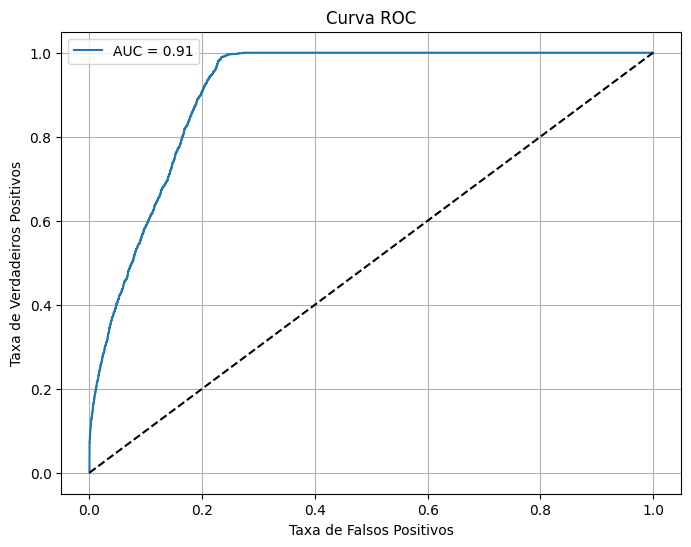

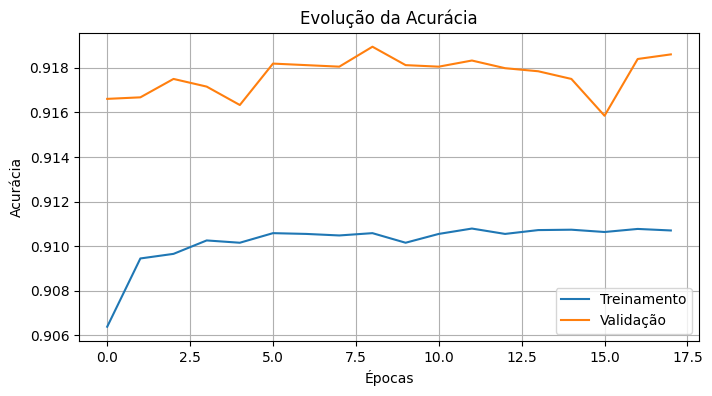

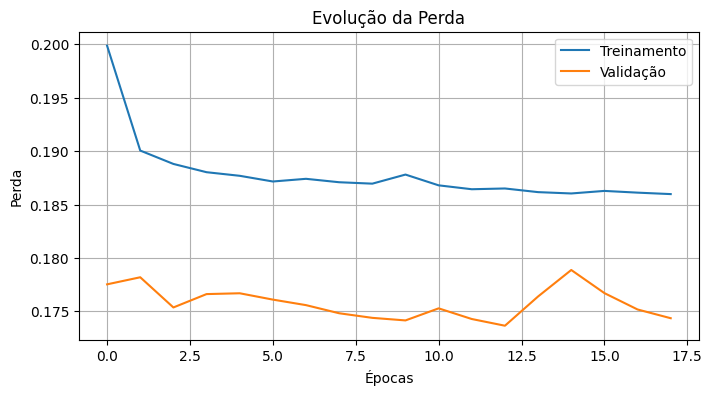


Matriz de Confusão:
[[16392    47]
 [ 1515   214]]


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import kerastuner as kt

# Carrega e prepara os dados
dados = pd.read_csv("neo.csv")
dados = dados.drop(['id', 'name', 'orbiting_body'], axis=1)

X = dados.drop("hazardous", axis=1)
y = dados["hazardous"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

# Função para construir o modelo com hiperparâmetros
def build_model(hp):
    modelo = Sequential()
    for i in range(hp.Int('num_layers', 1, 3)):
        modelo.add(Dense(
            units=hp.Int(f'units_{i}', min_value=8, max_value=64, step=8),
            activation='relu'))
    modelo.add(Dense(1, activation='sigmoid'))

    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    modelo.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return modelo

# Hiperparâmetro com RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=2,
    directory='tuner_dir',
    project_name='asteroid_classification'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(X_train, y_train,
             epochs=3,
             validation_split=0.2,
             batch_size=32,
             callbacks=[early_stopping])

# Melhores hiperparâmetros
best_hp = tuner.get_best_hyperparameters(1)[0]

# Modelo com os melhores hiperparâmetros
model = build_model(best_hp)

# Treinamento final com mais épocas
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0
)

# Avaliação final
y_prob = model.predict(X_test)
y_pred = (y_prob > 0.5).astype("int32")

print("\nRelatório de Classificação:\n")
print(classification_report(y_test, y_pred, target_names=["Não Perigoso", "Perigoso"]))

auc = roc_auc_score(y_test, y_prob)
print(f"\nAUC no teste: {auc:.2f}")

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.title('Curva ROC')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend()
plt.grid()
plt.show()

# Acurácia ao longo das épocas
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title("Evolução da Acurácia")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()
plt.grid()
plt.show()

# Perda ao longo das épocas
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title("Evolução da Perda")
plt.xlabel("Épocas")
plt.ylabel("Perda")
plt.legend()
plt.grid()
plt.show()

# Matriz de Confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred))
